In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 데이터 로드
data = pd.read_csv('employee_churn.csv')

# 'department' 열의 결측치 삭제
if 'department' in data.columns:
    data = data.drop('department', axis=1)

# 'filed_complaint'과 'recently_promoted' 컬럼 데이터의 결측값을 0으로 채우기
data['filed_complaint'] = data['filed_complaint'].fillna(0)
data['recently_promoted'] = data['recently_promoted'].fillna(0)

# 'tenure'컬럼 데이터 근속 연수를 구하므로 결측값을 1으로 채우기
data['tenure'] = data['tenure'].fillna(1)

# 'last_evaluation', 'satisfaction' 결측치를 평균값으로 대체
data['last_evaluation'] = data['last_evaluation'].fillna(data['last_evaluation'].mean())
data['satisfaction'] = data['satisfaction'].fillna(data['satisfaction'].mean())


# 수치형 데이터를 표준화
scaler = StandardScaler()
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# 범주형 변수를 Label Encoding 또는 One-Hot Encoding으로 변환
categorical_columns = data.select_dtypes(include=['object']).columns

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # 각 열의 인코더 저장 (나중에 해석 가능)

X = data.drop('status', axis=1)  # 이탈 여부 열을 제외한 데이터
y = data['status']  # 이탈 여부 열만 선택

# 학습 데이터와 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y

0        1
1        0
2        0
3        0
4        0
        ..
14244    0
14245    0
14246    1
14247    0
14248    0
Name: status, Length: 14249, dtype: int64


Model Accuracy: 0.9618

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2189
           1       0.90      0.94      0.92       661

    accuracy                           0.96      2850
   macro avg       0.94      0.95      0.95      2850
weighted avg       0.96      0.96      0.96      2850



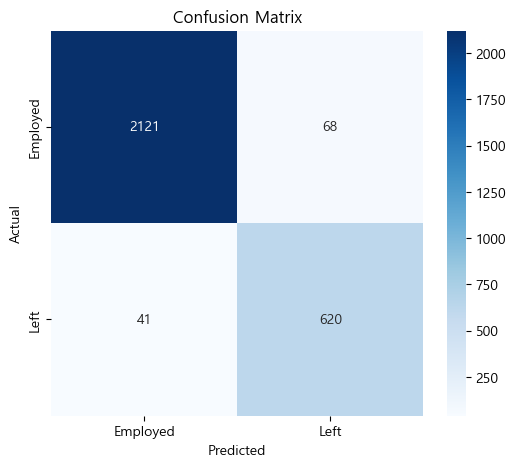

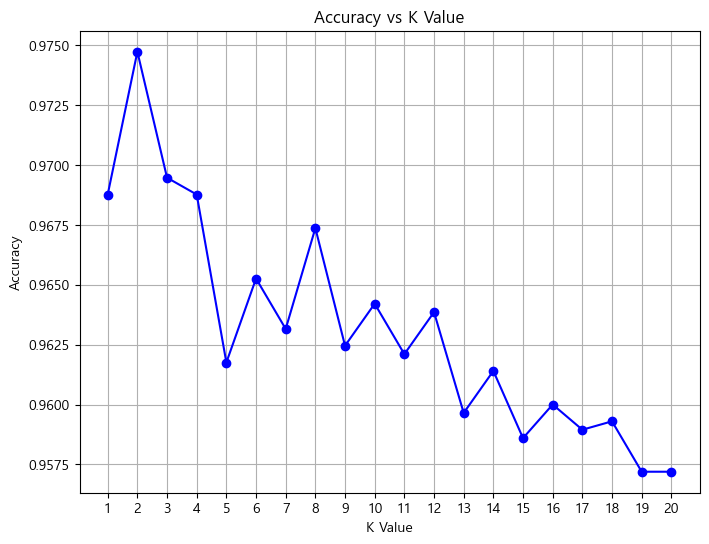

In [2]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. K-최근접 이웃 모델 생성
knn_model = KNeighborsClassifier(n_neighbors=5)  # K값 5로 설정

# 2. 모델 학습
knn_model.fit(X_train, y_train)

# 3. 예측
y_pred = knn_model.predict(X_test)

# 4. 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# 5. 분류 성능 평가
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 6. 혼동 행렬 (Confusion Matrix) 시각화
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Employed", "Left"], yticklabels=["Employed", "Left"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 7. 모델의 k 값 변경하여 성능 비교 (선택 사항)
k_values = range(1, 21)  # k값 1부터 20까지 시험
accuracy_scores = []

# 각 k 값에 대해 성능을 측정
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    y_pred = knn_model.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

# k 값에 따른 정확도 그래프
plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [3]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# 성능 평가 함수 정의
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

# KNN 모델 성능 평가
print("KNN Model Performance:")
evaluate_model(knn_model, X_test, y_test)

KNN Model Performance:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2189
           1       0.89      0.93      0.91       661

    accuracy                           0.96      2850
   macro avg       0.93      0.95      0.94      2850
weighted avg       0.96      0.96      0.96      2850

Accuracy: 0.9571929824561404
Precision: 0.8900144717800289
Recall: 0.9304084720121029
F1 Score: 0.9097633136094675


In [4]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# 하이퍼파라미터 그리드 정의
param_dist = {
    'n_neighbors': range(3, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean'],
    'leaf_size': [20, 30]
}

# RandomizedSearchCV로 하이퍼파라미터 탐색
random_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print(f"Best Parameters: {random_search.best_params_}")

# 최적의 모델 학습
best_knn_model = random_search.best_estimator_

# 성능 평가
evaluate_model(best_knn_model, X_test, y_test)

# 교차 검증 결과 출력
cv_scores = cross_val_score(best_knn_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean()} (+/- {cv_scores.std() * 2})")


C:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'minkowski', 'leaf_size': 30}
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2189
           1       0.92      0.96      0.94       661

    accuracy                           0.97      2850
   macro avg       0.95      0.97      0.96      2850
weighted avg       0.97      0.97      0.97      2850

Accuracy: 0.9719298245614035
Precision: 0.9191919191919192
Recall: 0.9636913767019667
F1 Score: 0.9409158050221565
Cross-Validation Accuracy: 0.9614003525707643 (+/- 0.003953587058123414)
